<a href="https://colab.research.google.com/github/Davron030901/PyTorch/blob/main/19_PyTorch_Lightening_Tutorial_Batch_and_LR_Selection%2C_Tensorboards%2C_Callbacks%2C_mGPU%2C_TPU_and_more.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PyTorch Lightning**
### **PyTorch Lightning is an open-source Python library that provides a high-level interface for PyTorch, a popular deep learning framework.**
---
https://pytorch-lightning.readthedocs.io/en/latest/
---

In this lesson, we learn to use the amazing library **PyTorch Lightning**. It's a great way to organize. your PyTorch code and get many great features and added benefits. We'll be doing the following in this guide:
1. Setup and Install Lightning
2. Organzing our code into the Lightning structure/design philosophy
3. Automatic Batch Selection
4. Automatic Learning Rate Selection
5. Training using Lightning
6. Tensorboard logs
7. Callbacks - Early Stopping,  Checkpoints and using Lightning Bolts Metrics
8. Saving and Loading Models from checkpoints
9. Saving as Torchscript for Production Deployment
10. Inferences
11. Multiple GPU Training
12. Training on TPUs
13. Profiler for finding Bottlenecks in Training
14. 16-Bit GPU Training

## **1. Setup and Install Lightning**

In [ ]:
!pip install torch torchvision torchaudio pytorch-lightning torchmetrics

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/models exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0      | train
1 | conv1    | Sequential         | 448    | train
2 | conv2    | Sequential         | 4.6 K  | train
3 | conv3    | Sequential         | 18.5 K | train
4 | fc1      | Sequential         | 442 K  | train
5 | fc2      | Sequential         | 258    | train
--------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866

CUDA available: False
Using device: cpu
Batch size manualy set to: 128
Model o'qitish boshlanmoqda...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Best model path: /content/models/catsvsdogs-epoch=04-val_loss=0.55.ckpt
Model TorchScript formatida saqlandi: model_cpu.pt


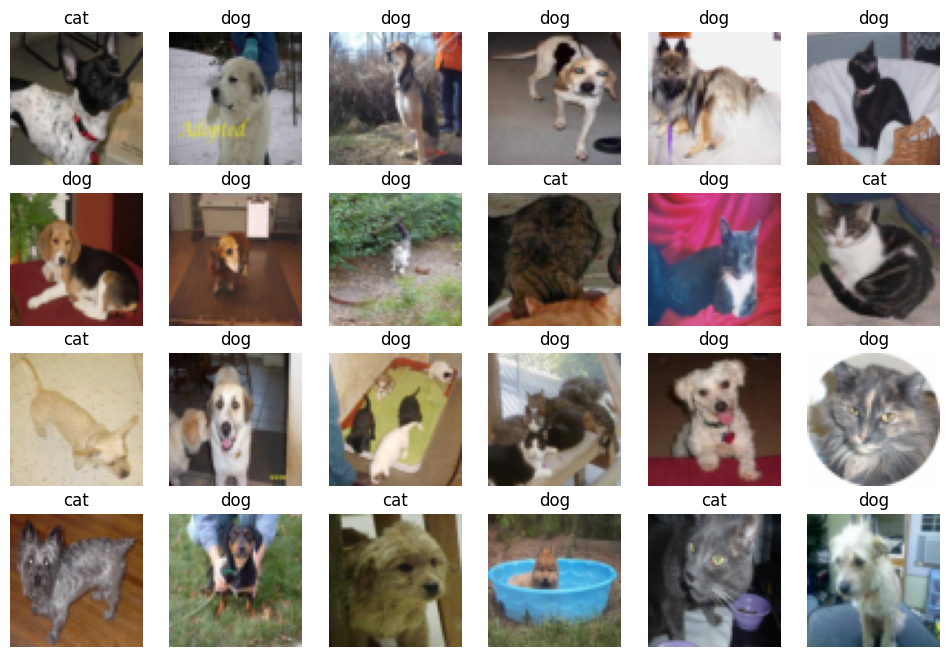

Bashorat natijalari saqlandi: cpu_predictions.png
CPU o'qitish yakunlandi


In [ ]:
# PyTorch Lightning - Soddalashtirilgan variant
# Kerakli kutubxonalarni o'rnatish
!pip install torch torchvision torchaudio pytorch-lightning torchmetrics

# Kerakli kutubxonalarni import qilish
import os
import torch
import torchmetrics
import torch.nn.functional as F

from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Dataset yuklab olish (agar fayl yuklangan bo'lmasa)
if not os.path.exists('./train'):
    !gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
    !unzip -q dogs-vs-cats.zip
    !unzip -q train.zip
    !unzip -q test1.zip

# Dataset yaratish
class Dataset():
    def __init__(self, filelist, filepath, transform=None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)

        if "dog" in imgpath:
            label = 1
        else:
            label = 0

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

# Yo'llarni belgilash
train_dir = './train'
test_dir = './test1'

# Fayl ro'yxatlarini olish
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

# Transformatsiyalarni belgilash
transformations = transforms.Compose([transforms.Resize((60, 60)), transforms.ToTensor()])

# Train va test datasetlarini yaratish
train_dataset = Dataset(train_files, train_dir, transformations)
val_dataset = Dataset(test_files, test_dir, transformations)

# Train va validation uchun ajratish
train, val = torch.utils.data.random_split(train_dataset, [20000, 5000])

# PyTorch Lightning modelini yaratish
class LitModel(pl.LightningModule):
    def __init__(self, learning_rate=0.001, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # Metrics
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2)

        # Model arxitekturasi
        self.conv1 = nn.Sequential(nn.Conv2d(3, 16, 3), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 3), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.conv3 = nn.Sequential(nn.Conv2d(32, 64, 3), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.fc1 = nn.Sequential(nn.Flatten(), nn.Linear(64*5*5, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(128, 2),)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(dataset=train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(dataset=val, batch_size=self.batch_size, shuffle=False)

    def training_step(self, batch, batch_idx):
        data, label = batch
        output = self.forward(data)
        loss = nn.CrossEntropyLoss()(output, label)
        self.log('train_loss', loss)
        self.log('train_acc_step', self.accuracy(output, label))
        return {'loss': loss}

    def on_train_epoch_end(self):
        self.log('train_acc_epoch', self.accuracy.compute())

    def validation_step(self, batch, batch_idx):
        val_data, val_label = batch
        val_output = self.forward(val_data)
        val_loss = nn.CrossEntropyLoss()(val_output, val_label)
        self.log('val_acc_step', self.accuracy(val_output, val_label))
        self.log('val_loss', val_loss)
        return {'val_loss': val_loss}

    def on_validation_epoch_end(self):
        self.log('val_acc_epoch', self.accuracy.compute())

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

# ====================== CPU bilan o'qitish ======================
# Device ni tekshirish
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device("cpu")
print(f"Using device: {device}")

# Early stopping va checkpoint uchun callback'lar
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    strict=False,
    verbose=False,
    mode='min'
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='models/',
    filename='catsvsdogs-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

# Model yaratish
model = LitModel(batch_size=32, learning_rate=0.001)

# MUHIM: Batch size qo'lda 128ga o'rnatiladi
model.batch_size = 128
print(f"Batch size manualy set to: {model.batch_size}")

# Tensorboard uchun logger
logger = TensorBoardLogger("lightning_logs", name="cats_vs_dogs")

# Modelni CPU da o'qitish
trainer = pl.Trainer(
    max_epochs=5,
    logger=logger,
    log_every_n_steps=10,
    callbacks=[early_stop, checkpoint_callback]
)

# Modelni o'qitish
print("Model o'qitish boshlanmoqda...")
trainer.fit(model)

# Eng yaxshi modelni yuklash
best_model_path = checkpoint_callback.best_model_path
print(f"Best model path: {best_model_path}")

if os.path.exists(best_model_path):
    best_model = LitModel.load_from_checkpoint(checkpoint_path=best_model_path)

    # Modelni TorchScript sifatida saqlash
    script = best_model.to_torchscript()
    torch.jit.save(script, "model_cpu.pt")
    print("Model TorchScript formatida saqlandi: model_cpu.pt")

    # Test ma'lumotlari ustida bashorat
    val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=32, shuffle=False)
    samples, _ = next(iter(val_loader))

    fig = plt.figure(figsize=(12, 8))
    fig.tight_layout()

    output = best_model(samples[:24])
    pred = torch.argmax(output, dim=1)
    pred = [p.item() for p in pred]
    ad = {0: 'cat', 1: 'dog'}

    for num, sample in enumerate(samples[:24]):
        plt.subplot(4, 6, num+1)
        plt.title(ad[pred[num]])
        plt.axis('off')
        sample = sample.numpy()
        plt.imshow(np.transpose(sample, (1, 2, 0)))

    plt.savefig('cpu_predictions.png')
    plt.show()
    print("Bashorat natijalari saqlandi: cpu_predictions.png")
else:
    print("Eng yaxshi model topilmadi!")

print("CPU o'qitish yakunlandi")

In [ ]:
best_model = LitModel.load_from_checkpoint("/content/models/model_cpu.pt")

FileNotFoundError: [Errno 2] No such file or directory: '/content/models/model_cpu.pt'

In [ ]:
# Kerakli kutubxonalarni import qilish
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torchmetrics

# Dataset yaratish
class Dataset:
    def __init__(self, filelist, filepath, transform=None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)
        label = 1 if "dog" in imgpath else 0
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

# Dataset va transformatsiyalarni tayyorlash
train_dir = './train'
train_files = os.listdir(train_dir) if os.path.exists(train_dir) else []
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
train_dataset = Dataset(train_files, train_dir, transform)
train, val = random_split(train_dataset, [20000, 5000]) if train_files else ([], [])

# PyTorch Lightning modeli
class LitModel(pl.LightningModule):
    def __init__(self, learning_rate=0.001, batch_size=32):
        super().__init__()
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.accuracy = torchmetrics.Accuracy(task="binary")

        # Kichraytirilgan arxitektura
        self.conv1 = nn.Sequential(nn.Conv2d(3, 8, 3), nn.ReLU(), nn.MaxPool2d(2))  # 8 kanal
        self.conv2 = nn.Sequential(nn.Conv2d(8, 16, 3), nn.ReLU(), nn.MaxPool2d(2)) # 16 kanal
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(16*6*6, 64), nn.ReLU(), nn.Linear(64, 2))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc(x)
        return x  # Softmax qo‘llamaymiz

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.accuracy(F.softmax(y_hat, dim=1), y))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss)
        self.log('val_acc', self.accuracy(F.softmax(y_hat, dim=1), y))
        return loss

    def train_dataloader(self):
        return DataLoader(train, batch_size=self.batch_size, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return DataLoader(val, batch_size=self.batch_size, num_workers=0)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

# Modelni sozlash va o'qitish
if __name__ == "__main__":
    print(f"Using CPU: {torch.device('cpu')}")
    model = LitModel(batch_size=32, learning_rate=0.001)

    # Trainer sozlamalari
    trainer = pl.Trainer(
        max_epochs=5,
        log_every_n_steps=10,
        devices="auto",
        accelerator="cpu",
        enable_checkpointing=False
    )

    # O'qitish
    if train_files:
        print("O'qitish boshlandi...")
        trainer.fit(model)
        torch.save(model.state_dict(), "model_cpu.pt")
        print("Model saqlandi: model_cpu.pt")
    else:
        print("Train papkasi topilmadi! Datasetni yuklang.")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type           | Params | Mode 
----------------------------------------------------
0 | accuracy | BinaryAccuracy | 0      | train
1 | conv1    | Sequential     | 224    | train
2 | conv2    | Sequential     | 1.2 K  | train
3 | fc       | Sequential     | 37.1 K | train
----------------------------------------------------
38.5 K    Trainable params
0         Non-trainable params
38.5 K    Total params
0.154     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Using CPU: cpu
O'qitish boshlandi...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

RuntimeError: Predictions and targets are expected to have the same shape, but got torch.Size([32, 2]) and torch.Size([32]).

In [ ]:
# Import all packages we'll be using

import os
import torch
import torchmetrics
import torch.nn.functional as F

from torch import nn
from torchvision import transforms,datasets
from torch.utils.data import DataLoader,Dataset, random_split

import pytorch_lightning as pl
# from pytorch_lightning.tuner import Tuner
from pytorch_lightning.loggers import TensorBoardLogger

from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [ ]:
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

CUDA available: False
Using device: cpu


#### **Download our datasets**

In [ ]:
!gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
From (redirected): https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk&confirm=t&uuid=f200b653-79d9-47e4-bedc-18a3fbfed383
To: /content/dogs-vs-cats.zip
100% 852M/852M [00:13<00:00, 64.2MB/s]


## **Setup our Dataloaders**

In [ ]:
class Dataset():
    def __init__(self, filelist, filepath, transform = None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)

        if "dog" in imgpath:
            label = 1
        else:
            label = 0

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)


# Set directory paths for our files
train_dir = './train'
test_dir = './test1'

# Get files in our directories
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

# Create our transforms
transformations = transforms.Compose([transforms.Resize((60,60)),transforms.ToTensor()])

# Create our train and test dataset objects
train = Dataset(train_files, train_dir, transformations)
val = Dataset(test_files, test_dir, transformations)

# Split into our train and validation
train, val = torch.utils.data.random_split(train,[20000,5000])

#train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)
#val_loader = torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

## **2. Organzing our code into the Lightning structure/design philosophy**

In [ ]:
class LitModel(pl.LightningModule):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.conv1 = nn.Sequential(nn.Conv2d(3,16,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(nn.Conv2d(16,32,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv3 = nn.Sequential(nn.Conv2d(32,64,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.fc1 = nn.Sequential(nn.Flatten(), nn.Linear(64*5*5,256), nn.ReLU(), nn.Linear(256,128), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(128,2),)

    def train_dataloader(self):
        # transforms
        return torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

    def cross_entropy_loss(self, logits, labels):
      return F.nll_loss(logits, labels)

    def training_step(self, batch, batch_idx):
        data, label = batch
        output = self.forward(data)
        loss = nn.CrossEntropyLoss()(output,label)
        self.log('train_loss', loss)
        return {'loss': loss, 'log': self.log}

    def validation_step(self, batch, batch_idx):
        val_data, val_label = batch
        val_output = self.forward(val_data)
        val_loss = nn.CrossEntropyLoss()(val_output, val_label)
        self.log('val_loss', val_loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x,dim = 1)

## **3. Automatic Batch Selection**

In [ ]:
# trainer = pl.Trainer()
model = LitModel(batch_size = 32)
trainer = pl.Trainer(auto_scale_batch_size=True)
# trainer = pl.Trainer(auto_scale_batch_size='binsearch')

trainer.tune(model)

INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.tuner.batch_size_scaling:Batch size 2 succeeded, trying batch size 4
INFO:pytorch_lightning.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.tuner.batch_size_scaling:Batch size 4 succeeded, trying batch size 8
INFO:pytorch_lightning.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.tuner.batch_size_scaling:Batch size 8 succeeded, trying batch size 16
INFO:pytorch_lightning.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.tuner.batch_size_scaling:Batch size 16 succeeded, trying batch size 32
INFO:pytorch_lightning.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.tuner.batch_size_scaling:Batch size 32 succeeded, trying bat

{'scale_batch_size': 20000}

## **4. Automatic Learning Rate Selection**

Edit the Lightning Module as shown below. Note we've added in new lines at Line 5 to 8.

In [ ]:
class LitModel(pl.LightningModule):
    def __init__(self, learning_rate, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.learning_rate = learning_rate #For binary classification (cats vs dogs is binary)
        # self.accuracy = torchmetrics.Accuracy(task="binary")
        # self.train_acc = torchmetrics.Accuracy(task="binary")
        # self.valid_acc = torchmetrics.Accuracy(task="binary")
        self.accuracy = torchmetrics.Accuracy() #
        self.train_acc = torchmetrics.Accuracy() #
        self.valid_acc = torchmetrics.Accuracy() #
        self.conv1 = nn.Sequential(nn.Conv2d(3,16,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(nn.Conv2d(16,32,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv3 = nn.Sequential(nn.Conv2d(32,64,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.fc1 = nn.Sequential(nn.Flatten(), nn.Linear(64*5*5,256), nn.ReLU(), nn.Linear(256,128), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(128,2),)

# Or for multiclass classification (if you had more than 2 classes)
# self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2)
# self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
# self.valid_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)

    def train_dataloader(self):
        # transforms
        return torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

    def cross_entropy_loss(self, logits, labels):
      return F.nll_loss(logits, labels)

    def training_step(self, batch, batch_idx):
        data, label = batch
        output = self.forward(data)
        loss = nn.CrossEntropyLoss()(output,label)
        self.log('train_loss', loss)
        self.log('train_acc_step', self.accuracy(output, label))
        return {'loss': loss, 'log': self.log}

    def training_epoch_end(self, outs):
        # log epoch metric
        self.log('train_acc_epoch', self.accuracy.compute())

    def validation_step(self, batch, batch_idx):
        val_data, val_label = batch
        val_output = self.forward(val_data)
        val_loss = nn.CrossEntropyLoss()(val_output, val_label)
        self.log('val_acc_step', self.accuracy(val_output, val_label))
        self.log('val_loss', val_loss)

    def validation_epoch_end(self, outs):
        # log epoch metric
        self.log('val_acc_epoch', self.accuracy.compute())

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=(self.learning_rate))
        return optimizer

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x,dim = 1)

In [ ]:
# Define your custom Dataset class
class CatsDogsDataset(Dataset):
    def __init__(self, filelist, filepath, transform=None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)

        if "dog" in imgpath:
            label = 1
        else:
            label = 0

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

INFO:pytorch_lightning.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | train_acc | BinaryAccuracy | 0     
2 | valid_acc | BinaryAccuracy | 0     
3 | conv1     | Sequential     | 448   
4 | conv2     | Sequential     | 4.6 K 
5 | conv3     | Sequential     | 18.5 K
6 | fc1       | Sequential     | 442 K 
7 | fc2       | Sequential     | 258   
---------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model params size (MB)


Train dataset size: 20000
Validation dataset size: 5000
Train dataset size: 20000
Validation dataset size: 5000


Validation sanity check: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training completed!


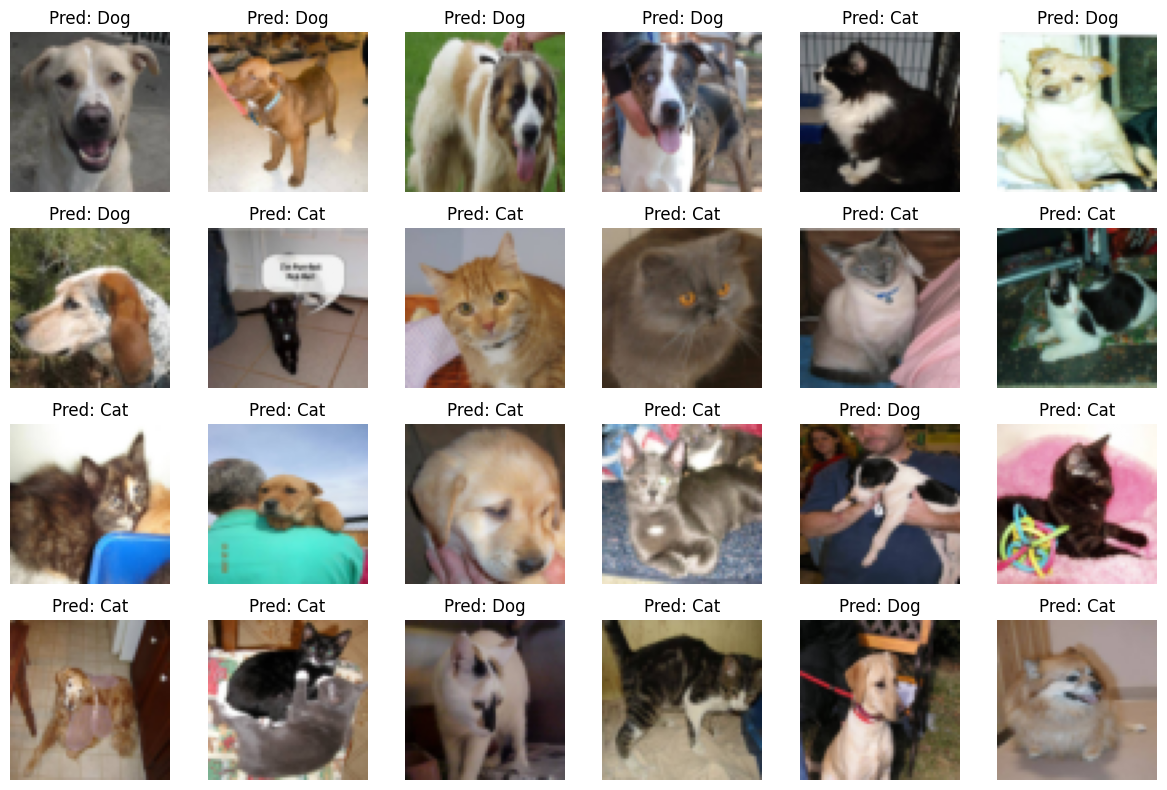

In [ ]:
# # Define the PyTorch Lightning model
# class LitModel(pl.LightningModule):
#     def __init__(self, learning_rate=0.001, batch_size=32):
#         super().__init__()
#         self.batch_size = batch_size
#         self.learning_rate = learning_rate

#         # For torchmetrics 0.9.0+, specify task
#         self.accuracy = torchmetrics.Accuracy(task="binary")
#         self.train_acc = torchmetrics.Accuracy(task="binary", num_classes=2)
#         self.valid_acc = torchmetrics.Accuracy(task="binary", num_classes=2)

#         # CNN layers
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(3, 16, 3),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2)
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(16, 32, 3),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2)
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(32, 64, 3),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2)
#         )

#         # Fully connected layers
#         self.fc1 = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(64*5*5, 256),
#             nn.ReLU(),
#             nn.Linear(256, 128),
#             nn.ReLU()
#         )
#         self.fc2 = nn.Sequential(
#             nn.Linear(128, 2)
#         )

#         # Save hyperparameters for automatic logging
#         self.save_hyperparameters()

#         # Store train and val datasets
#         self.train_dataset = None
#         self.val_dataset = None

#     def setup(self, stage=None):
#         # Define transformations
#         transformations = transforms.Compose([
#             transforms.Resize((60, 60)),
#             transforms.ToTensor()
#         ])

#         # Set paths and get file lists
#         train_dir = './train'
#         test_dir = './test1'

#         if os.path.exists(train_dir) and os.path.exists(test_dir):
#             train_files = os.listdir(train_dir)
#             test_files = os.listdir(test_dir)

#             # Create full dataset
#             full_dataset = CatsDogsDataset(train_files, train_dir, transformations)

#             # Split into train and validation
#             train_size = int(0.8 * len(full_dataset))
#             val_size = len(full_dataset) - train_size

#             self.train_dataset, self.val_dataset = random_split(
#                 full_dataset, [train_size, val_size]
#             )

#             print(f"Train dataset size: {len(self.train_dataset)}")
#             print(f"Validation dataset size: {len(self.val_dataset)}")

#     def train_dataloader(self):
#         return DataLoader(
#             dataset=self.train_dataset,
#             batch_size=self.batch_size,
#             shuffle=True,
#             num_workers=2  # Reduce for Colab to avoid memory issues
#         )

#     def val_dataloader(self):
#         return DataLoader(
#             dataset=self.val_dataset,
#             batch_size=self.batch_size,
#             shuffle=False,
#             num_workers=2  # Reduce for Colab to avoid memory issues
#         )

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.fc1(x)
#         x = self.fc2(x)
#         return F.softmax(x, dim=1)

#     def training_step(self, batch, batch_idx):
#         data, label = batch
#         output = self(data)
#         loss = nn.CrossEntropyLoss()(output, label)

#         # Get predicted class (convert from [batch_size, 2] to [batch_size])
#         _, preds = torch.max(output, dim=1)

#         # Log metrics with the correct format
#         self.log('train_loss', loss, prog_bar=True)
#         self.log('train_acc', self.train_acc(preds, label), prog_bar=True)

#         return {'loss': loss}

#     def on_training_epoch_end(self):
#         # Log epoch metrics
#         self.log('train_acc_epoch', self.train_acc.compute(), prog_bar=True)
#         # Reset metrics for next epoch
#         self.train_acc.reset()

#     def validation_step(self, batch, batch_idx):
#         data, label = batch
#         output = self(data)
#         loss = nn.CrossEntropyLoss()(output, label)

#         # Get predicted class
#         _, preds = torch.max(output, dim=1)

#         # Log metrics with the correct format
#         self.log('val_loss', loss, prog_bar=True)
#         self.log('val_acc', self.valid_acc(preds, label), prog_bar=True)

#         return {'val_loss': loss}

#     def on_validation_epoch_end(self):
#         # Log epoch metrics
#         self.log('val_acc_epoch', self.valid_acc.compute(), prog_bar=True)
#         # Reset metrics for next epoch
#         self.valid_acc.reset()

#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

# # Create visualization function
# def show_predictions(model, val_dataset, num_images=24):
#     # Create a DataLoader with batch_size=num_images
#     dataloader = DataLoader(val_dataset, batch_size=num_images, shuffle=True)

#     # Get a batch of images
#     images, labels = next(iter(dataloader))

#     # Move to the same device as model
#     images = images.to(model.device)

#     # Get predictions
#     with torch.no_grad():
#         outputs = model(images)
#         _, predicted = torch.max(outputs, 1)

#     # Move back to CPU for plotting
#     images = images.cpu()
#     predicted = predicted.cpu()

#     # Plot
#     fig = plt.figure(figsize=(12, 8))
#     for i in range(num_images):
#         ax = plt.subplot(4, 6, i + 1)
#         img = images[i].permute(1, 2, 0)  # Change from CxHxW to HxWxC
#         plt.imshow(img)
#         plt.title(f"Pred: {'Dog' if predicted[i] == 1 else 'Cat'}")
#         plt.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Main execution
# def train_cats_dogs_model():
#     # Set seeds for reproducibility
#     pl.seed_everything(42)

#     # Create model
#     model = LitModel(learning_rate=0.001, batch_size=32)

#     # Set up callbacks
#     checkpoint_callback = ModelCheckpoint(
#         monitor='val_loss',
#         dirpath='./checkpoints/',
#         filename='cats-dogs-{epoch:02d}-{val_loss:.2f}',
#         save_top_k=3,
#         mode='min'
#     )

#     early_stop_callback = EarlyStopping(
#         monitor='val_loss',
#         patience=5,
#         mode='min'
#     )

#     # Create trainer
#     trainer = pl.Trainer(
#         max_epochs=10,
#         callbacks=[checkpoint_callback, early_stop_callback],
#         accelerator="auto",  # Auto-select GPU if available
#         devices=1,
#         logger=True
#     )

#     # Setup the data
#     model.setup()

#     # Train the model
#     trainer.fit(model)

#     # Save the model
#     trainer.save_checkpoint("cats_dogs_model.ckpt")

#     print("Training completed!")

#     # Show some predictions
#     show_predictions(model, model.val_dataset)

#     return model

# # Run the training
# trained_model = train_cats_dogs_model()

### **Implement our Automatic Learning Rate Tuner**

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

model = LitModel(batch_size = 32, learning_rate=0.001)

# Learning Rate Logger
trainer = pl.Trainer(gpus=1, auto_lr_find=True)

# Results can be found in
trainer.tune(model)

### **Visualize the LR vs Loss Plot**

The figure produced by lr_finder.plot() should look something like the figure below. It is recommended to not pick the learning rate that achieves the lowest loss, but instead something in the middle of the sharpest downward slope (red point). This is the point returned py lr_finder.suggestion().

lr_finder = trainer.tuner.lr_find(model)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

## **5. Train Model with learned Batch Size and Learning Rate**

The learning rate and batch size stored in `/content/lr_find_temp_model.ckpt`  and `/content/scale_batch_size_temp_model.ckpt` respectively, will be used over the learning rate set and batch sizes we set.


In [ ]:
# init model
model = LitModel(batch_size = 32, learning_rate=0.001)

# Initialize a trainer
trainer = pl.Trainer(gpus=1, max_epochs=10, progress_bar_refresh_rate=10)

# Train the model ⚡
trainer.fit(model)

## **Tensorboard logs**

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## **6. Using Callbacks - Early Stopping & Checkpointing**

**Early Stopping** -  early stopping is a form of regularization used to avoid overfitting when training a learner with an iterative method, such as gradient descent.

![](https://cdn-images-1.medium.com/max/920/1*iAK5uMoOlX1gZu-cSh1nZw.png)

**Model Checkpoint** - ModelCheckpoint callback is used to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

In [ ]:
# Setup Early Stopping
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    strict = False,
    verbose = False,
    mode = 'min'
)

# Setup Model Checkpoint
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='models/',
    filename='sample-catsvsdogs-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,# We save the top 3 models
    mode='min',
)

In [ ]:
# We can even use some custom callbacks
class MyPrintingCallback(pl.callbacks.base.Callback):

    def on_init_start(self, trainer):
        print('Starting to init trainer!')

    def on_init_end(self, trainer):
        print('trainer is init now')

    def on_train_end(self, trainer, pl_module):
        print('do something when training ends')

### **Train with our Callbacks**

In [ ]:
# init model
model = LitModel(batch_size = 32, learning_rate=0.001)

# Initialize a trainer
trainer = pl.Trainer(
    gpus=1,
    max_epochs=10,
    progress_bar_refresh_rate=10,
    callbacks=[EarlyStopping('val_loss'), checkpoint_callback, MyPrintingCallback()]
)

trainer.fit(model)

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## **8. Restore from Checkpoints**

In [ ]:
# Get path of best model
checkpoint_callback.best_model_path

### **Load and run inference using the best checkpoint model**

In [ ]:
#loading the best checkpoints to model
pretrained_model = LitModel.load_from_checkpoint(batch_size = 32, learning_rate=0.001, checkpoint_path = checkpoint_callback.best_model_path)
pretrained_model = pretrained_model.to("cuda")
pretrained_model.eval()
pretrained_model.freeze()

## **9. Save our Model for Production Deployments**

**Exporting to TorchScript**

TorchScript allows you to serialize your models in a way that it can be loaded in non-Python environments. The LightningModule has a handy method to_torchscript() that returns a scripted module which you can save or directly use.

In [ ]:
model = LitModel.load_from_checkpoint(batch_size = 32, learning_rate=0.001, checkpoint_path = checkpoint_callback.best_model_path)

script = model.to_torchscript()

# save for use in production environment
torch.jit.save(script, "model.pt")

## **10. Run inference on 32 images from our test data loder**

In [ ]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
samples, _ = iter(val_loader).next()
samples = samples.to('cuda')

fig = plt.figure(figsize=(12, 8))
fig.tight_layout()

output = pretrained_model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}

for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))

## **11. Multi-GPU Training**

To train on CPU/GPU/TPU without changing your code, we need to build a few good habits :)

Delete all `.cuda()` or `.to()` calls.

**Synchronize validation and test logging**

When running in distributed mode, we have to ensure that the validation and test step logging calls are synchronized across processes. This is done by adding sync_dist=True to all self.log calls in the validation and test step. This ensures that each GPU worker has the same behaviour when tracking model checkpoints, which is important for later downstream tasks such as testing the best checkpoint across all workers.

Note if you use any built in metrics or custom metrics that use the Metrics API, these do not need to be updated and are automatically handled for you.

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        # Add sync_dist=True to sync logging across all GPU workers
        self.log('validation_loss', loss, on_step=True, on_epoch=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        # Add sync_dist=True to sync logging across all GPU workers
        self.log('test_loss', loss, on_step=True, on_epoch=True, sync_dist=True)

There are other good practices that we don't use here, but they acn be found ehre - https://pytorch-lightning.readthedocs.io/en/latest/advanced/multi_gpu.html

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


CUDA available: True
Using device: cuda
Model o'qitish boshlanmoqda...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0      | train
1 | conv1    | Sequential         | 448    | train
2 | conv2    | Sequential         | 4.6 K  | train
3 | conv3    | Sequential         | 18.5 K | train
4 | fc1      | Sequential         | 442 K  | train
5 | fc2      | Sequential         | 258    | train
--------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.648


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 0.586


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.549


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.533
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.profilers.profiler:FIT Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                               	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Training is finished!
Best model path: /content/models/gpu-catsvsdogs-epoch=04-val_loss=0.53.ckpt
Model TorchScript formatida saqlandi: model_gpu.pt


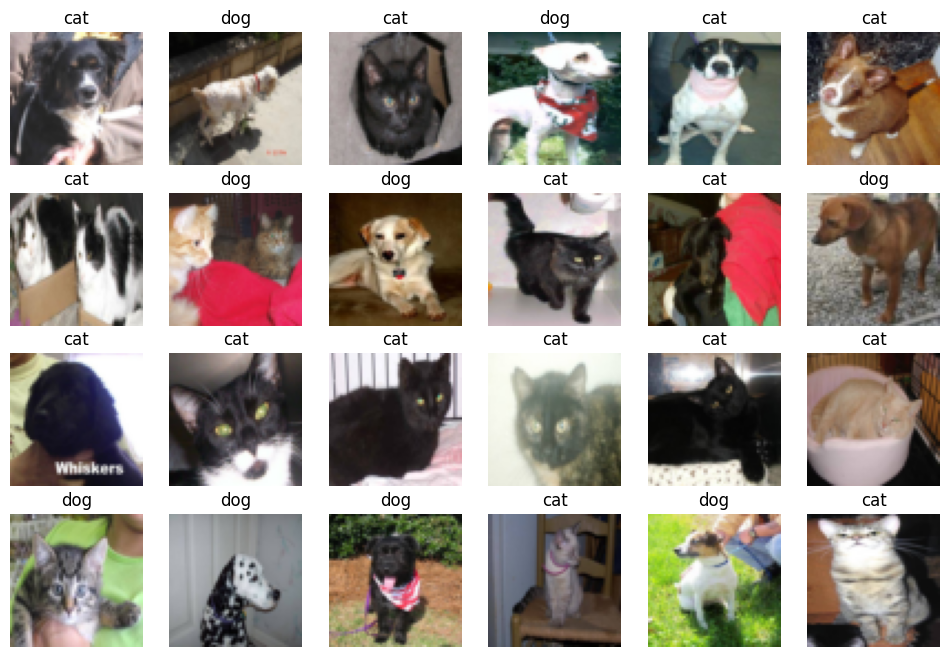

Bashorat natijalari saqlandi: gpu_predictions.png
Profiler natijalari:
FIT Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                               	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                     

In [2]:
# PyTorch Lightning bo'yicha kod - GPU versiyasi (o'zgartirilgan)
# Kerakli kutubxonalarni o'rnatish
!pip install torch torchvision torchaudio pytorch-lightning torchmetrics

# Kerakli kutubxonalarni import qilish
import os
import torch
import torchmetrics
import torch.nn.functional as F

from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Dataset yuklab olish (agar fayllar mavjud bo'lmasa)
if not os.path.exists('./train'):
    !gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
    !unzip -q dogs-vs-cats.zip
    !unzip -q train.zip
    !unzip -q test1.zip

# GPU mavjudligini tekshirish
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Agar GPU mavjud bo'lmasa, xabar berish
if not torch.cuda.is_available():
    print("OGOHLANTIRISH: GPU topilmadi. Iltimos, Colab'da GPU yoqilganligini tekshiring")
    print("Runtime -> Change runtime type -> Hardware accelerator -> GPU")

# Dataset yaratish
class Dataset():
    def __init__(self, filelist, filepath, transform=None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)

        if "dog" in imgpath:
            label = 1
        else:
            label = 0

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

# Yo'llarni belgilash
train_dir = './train'
test_dir = './test1'

# Fayl ro'yxatlarini olish
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

# Transformatsiyalarni belgilash
transformations = transforms.Compose([transforms.Resize((60, 60)), transforms.ToTensor()])

# Train va test datasetlarini yaratish
train_dataset = Dataset(train_files, train_dir, transformations)
val_dataset = Dataset(test_files, test_dir, transformations)

# Train va validation uchun ajratish
train, val = torch.utils.data.random_split(train_dataset, [20000, 5000])

# PyTorch Lightning modelini yaratish
class LitModel(pl.LightningModule):
    def __init__(self, learning_rate=0.001, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # Metrics - GPU uchun xususiy konfiguratsiya
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2)

        # Model arxitekturasi
        self.conv1 = nn.Sequential(nn.Conv2d(3, 16, 3), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 3), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.conv3 = nn.Sequential(nn.Conv2d(32, 64, 3), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.fc1 = nn.Sequential(nn.Flatten(), nn.Linear(64*5*5, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(128, 2),)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            dataset=train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2,  # Colab uchun 2 yetarli
            pin_memory=True
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            dataset=val,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2,  # Colab uchun 2 yetarli
            pin_memory=True
        )

    def training_step(self, batch, batch_idx):
        data, label = batch
        output = self.forward(data)
        loss = nn.CrossEntropyLoss()(output, label)
        self.log('train_loss', loss)
        self.log('train_acc_step', self.accuracy(output, label))
        return {'loss': loss}

    def on_train_epoch_end(self):
        # log epoch metric
        self.log('train_acc_epoch', self.accuracy.compute())

    def validation_step(self, batch, batch_idx):
        val_data, val_label = batch
        val_output = self.forward(val_data)
        val_loss = nn.CrossEntropyLoss()(val_output, val_label)
        self.log('val_acc_step', self.accuracy(val_output, val_label))
        self.log('val_loss', val_loss, sync_dist=True)  # sync_dist=True ga e'tibor bering (multi-GPU uchun)
        return {'val_loss': val_loss}

    def on_validation_epoch_end(self):
        # log epoch metric
        self.log('val_acc_epoch', self.accuracy.compute(), sync_dist=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        # GPU uchun o'rganish tezligi jadvalini qo'shing
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss"
            }
        }

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

# 16-bit precision bilan ishlash uchun callback - to'g'ri Callback classidan vorislanadi
class MyPrintingCallback(Callback):  # pl.callbacks.base.Callback o'rniga to'g'ridan-to'g'ri Callback
    def on_init_start(self, trainer):
        print('Starting to init trainer!')

    def on_init_end(self, trainer):
        print('Trainer is initialized now')

    def on_train_end(self, trainer, pl_module):
        print('Training is finished!')

# Early stopping va checkpoint uchun callback'lar
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    strict=False,
    verbose=True,
    mode='min'
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='models/',
    filename='gpu-catsvsdogs-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

# Lightning profiler qo'shish - GPU xarakteristikalarini nazorat qilish uchun
from pytorch_lightning.profilers import SimpleProfiler
profiler = SimpleProfiler()

# Model yaratish
model = LitModel(batch_size=128, learning_rate=0.001)

# Tensorboard uchun logger
logger = TensorBoardLogger("lightning_logs", name="cats_vs_dogs_gpu")

# GPU mavjud bo'lsa GPU-da, bo'lmasa CPU-da ishlash
if torch.cuda.is_available():
    # Modelni GPU da o'qitish (16-bit precision bilan)
    trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,  # 1 ta GPU
        max_epochs=5,
        logger=logger,
        log_every_n_steps=10,
        callbacks=[early_stop, checkpoint_callback, MyPrintingCallback()],
        profiler=profiler,
        precision="16-mixed"  # 16-bit precision with mixed precision training
    )
else:
    # CPU-da oddiy precision
    trainer = pl.Trainer(
        max_epochs=5,
        logger=logger,
        log_every_n_steps=10,
        callbacks=[early_stop, checkpoint_callback, MyPrintingCallback()],
        profiler=profiler
    )

# Modelni o'qitish
print("Model o'qitish boshlanmoqda...")
trainer.fit(model)

# Eng yaxshi modelni yuklash
best_model_path = checkpoint_callback.best_model_path
print(f"Best model path: {best_model_path}")

if os.path.exists(best_model_path):
    best_model = LitModel.load_from_checkpoint(checkpoint_path=best_model_path)
    best_model = best_model.to(device)
    best_model.eval()
    best_model.freeze()

    # Modelni TorchScript sifatida saqlash (deployment uchun)
    script = best_model.to_torchscript()
    torch.jit.save(script, "model_gpu.pt")
    print("Model TorchScript formatida saqlandi: model_gpu.pt")

    # Test ma'lumotlari ustida bashorat
    val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=32, shuffle=False)
    samples, _ = next(iter(val_loader))
    samples = samples.to(device)

    fig = plt.figure(figsize=(12, 8))
    fig.tight_layout()

    output = best_model(samples[:24])
    pred = torch.argmax(output, dim=1)
    pred = [p.item() for p in pred]
    ad = {0: 'cat', 1: 'dog'}

    for num, sample in enumerate(samples[:24]):
        plt.subplot(4, 6, num+1)
        plt.title(ad[pred[num]])
        plt.axis('off')
        sample = sample.cpu().numpy()
        plt.imshow(np.transpose(sample, (1, 2, 0)))

    plt.savefig('gpu_predictions.png')
    plt.show()
    print("Bashorat natijalari saqlandi: gpu_predictions.png")

    # Profiler natijasini ko'rish
    print("Profiler natijalari:")
    print(profiler.summary())
else:
    print("Eng yaxshi model topilmadi!")

print("GPU/CPU o'qitish yakunlandi")

In [ ]:
class LitModel_mGPU(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.accuracy = torchmetrics.Accuracy()
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.conv1 = nn.Sequential(nn.Conv2d(3,16,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(nn.Conv2d(16,32,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv3 = nn.Sequential(nn.Conv2d(32,64,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.fc1 = nn.Sequential(nn.Flatten(), nn.Linear(64*5*5,256), nn.ReLU(), nn.Linear(256,128), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(128,2),)

    def train_dataloader(self):
        # transforms
        return torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

    def cross_entropy_loss(self, logits, labels):
      return F.nll_loss(logits, labels)

    def training_step(self, batch, batch_idx):
        data, label = batch
        output = self.forward(data)
        loss = nn.CrossEntropyLoss()(output,label)
        self.log('train_loss', loss)
        self.log('train_acc_step', self.accuracy(output, label))
        return {'loss': loss, 'log': self.log}

    def training_epoch_end(self, outs):
        # log epoch metric
        self.log('train_acc_epoch', self.accuracy.compute())

    def validation_step(self, batch, batch_idx):
        val_data, val_label = batch
        val_output = self.forward(val_data)
        val_loss = nn.CrossEntropyLoss()(val_output, val_label)
        self.log('val_loss', val_loss, on_step=True, on_epoch=True, sync_dist=True)

    def validation_epoch_end(self, outs):
        # log epoch metric
        self.log('val_acc_epoch', self.accuracy.compute())

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)
        return optimizer

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x,dim = 1)

###**Select GPU devices**
You can select the GPU devices using ranges, a list of indices or a string containing a comma separated list of GPU ids:

In [ ]:
# DEFAULT (int) specifies how many GPUs to use per node
#pl.Trainer(gpus=k)

# Above is equivalent to
#pl.Trainer(gpus=list(range(k)))

# Specify which GPUs to use (don't use when running on cluster)
#pl.Trainer(gpus=[0, 1])

# Equivalent using a string
#pl.Trainer(gpus='0, 1')

# To use all available GPUs put -1 or '-1'
# equivalent to list(range(torch.cuda.device_count()))
#pl.Trainer(gpus=-1)

#### **Note: In Colab we only have one GPU so this won't speed thigns up here**

In [ ]:
# init model
model = LitModel_mGPU()

# Initialize a trainer
trainer = pl.Trainer(
    gpus=1,
    max_epochs=10,
    progress_bar_refresh_rate=10,
    callbacks=[EarlyStopping('val_loss'), checkpoint_callback, MyPrintingCallback()]
)

trainer.fit(model)

## **12. Profiler - Performance and Bottleneck Profiler**

In [ ]:
# init model
model = LitModel_mGPU()

# Initialize a trainer
trainer = pl.Trainer(
    gpus=1,
    max_epochs=1,
    progress_bar_refresh_rate=10,
    profiler="simple"
)

trainer.fit(model)

## **13. Training on TPUs**

**Tensor Processing Unit** is an AI accelerator application-specific integrated circuit developed by Google specifically for neural network machine learning.

**TPU Terminology**

A TPU is a Tensor processing unit. Each TPU has 8 cores where each core is optimized for 128x128 matrix multiplies. In general, a single TPU is about as fast as 5 V100 GPUs!

A TPU pod hosts many TPUs on it. Currently, TPU pod v2 has 2048 cores! You can request a full pod from Google cloud or a “slice” which gives you some subset of those 2048 cores.

In [ ]:
# PyTorch Lightning bo'yicha kod - TPU versiyasi
# TPU uchun maxsus kutubxonalarni o'rnatish
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl
!pip install pytorch-lightning torchmetrics

# Kerakli kutubxonalarni import qilish
import os
import torch
import torchmetrics
import torch.nn.functional as F

from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# TPU uchun XLA kutubxonasini import qilish
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl_loader
import torch_xla.distributed.xla_multiprocessing as xmp

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Dataset yuklab olish
!gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip

# TPU mavjudligini tekshirish
print("TPU checking...")
try:
    tpu = xm.xla_device()
    print(f"TPU available: {tpu}")
except:
    print("TPU not available in this Colab instance")
    print("Please change runtime type to TPU in the Colab menu:")
    print("Runtime -> Change runtime type -> Hardware accelerator -> TPU")

# Dataset yaratish
class Dataset():
    def __init__(self, filelist, filepath, transform=None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)

        if "dog" in imgpath:
            label = 1
        else:
            label = 0

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

# Yo'llarni belgilash
train_dir = './train'
test_dir = './test1'

# Fayl ro'yxatlarini olish
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

# Transformatsiyalarni belgilash
transformations = transforms.Compose([transforms.Resize((60, 60)), transforms.ToTensor()])

# Train va test datasetlarini yaratish
train_dataset = Dataset(train_files, train_dir, transformations)
val_dataset = Dataset(test_files, test_dir, transformations)

# Train va validation uchun ajratish
train, val = torch.utils.data.random_split(train_dataset, [20000, 5000])

# PyTorch Lightning modelini yaratish - TPU uchun moslashtirilgan
class LitModelTPU(pl.LightningModule):
    def __init__(self, learning_rate=0.001, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # Metrics
        self.accuracy = torchmetrics.Accuracy()
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()

        # Model arxitekturasi
        self.conv1 = nn.Sequential(nn.Conv2d(3, 16, 3), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 3), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.conv3 = nn.Sequential(nn.Conv2d(32, 64, 3), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.fc1 = nn.Sequential(nn.Flatten(), nn.Linear(64*5*5, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(128, 2),)

    def train_dataloader(self):
        # TPU uchun maxsus loader
        train_loader = torch.utils.data.DataLoader(
            dataset=train,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True,  # TPU uchun muhim, chunki TPU o'lchamlar bir xil bo'lishini talab qiladi
        )
        return train_loader

    def val_dataloader(self):
        # TPU uchun maxsus loader
        val_loader = torch.utils.data.DataLoader(
            dataset=val,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=True,
        )
        return val_loader

    def training_step(self, batch, batch_idx):
        data, label = batch
        output = self.forward(data)
        loss = nn.CrossEntropyLoss()(output, label)
        self.log('train_loss', loss)
        self.log('train_acc_step', self.accuracy(output, label))
        return {'loss': loss}

    def training_epoch_end(self, outs):
        # log epoch metric
        self.log('train_acc_epoch', self.accuracy.compute())

    def validation_step(self, batch, batch_idx):
        val_data, val_label = batch
        val_output = self.forward(val_data)
        val_loss = nn.CrossEntropyLoss()(val_output, val_label)
        # TPU uchun sync_dist=True parametrini qo'shish
        self.log('val_acc_step', self.accuracy(val_output, val_label), sync_dist=True)
        self.log('val_loss', val_loss, sync_dist=True)
        return {'val_loss': val_loss}

    def validation_epoch_end(self, outs):
        # log epoch metric with sync_dist=True
        self.log('val_acc_epoch', self.accuracy.compute(), sync_dist=True)

    def configure_optimizers(self):
        # TPU uchun optimallashtirish
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

# Early stopping va checkpoint uchun callback'lar
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    strict=False,
    verbose=True,
    mode='min'
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='models/',
    filename='tpu-catsvsdogs-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

# TPU uchun model yaratish
model = LitModelTPU(batch_size=32, learning_rate=0.001)

# Tensorboard uchun logger
logger = TensorBoardLogger("lightning_logs", name="cats_vs_dogs_tpu")

# TPU trainer yaratish
trainer = pl.Trainer(
    tpu_cores=8,  # 8 ta core TPU uchun
    max_epochs=10,
    logger=logger,
    callbacks=[early_stop, checkpoint_callback],
)

# TPU bilan Learning rate finder ni ishlatib bo'lmaydi,
# shuning uchun o'zimiz aniq qiymat beramiz

# Modelni o'qitish
trainer.fit(model)

# TPU uchun maxsus deploy qismi
def tpu_inference_setup():
    # TPU uchun eng yaxshi modelni yuklash
    best_model_path = checkpoint_callback.best_model_path
    print(f"Best model path: {best_model_path}")

    best_model = LitModelTPU.load_from_checkpoint(checkpoint_path=best_model_path)
    best_model.eval()
    best_model.freeze()

    # Modelni TPU qurilmasiga ko'chirish
    device = xm.xla_device()
    best_model = best_model.to(device)

    # Modelni TorchScript sifatida saqlash
    script = best_model.to_torchscript()
    torch.jit.save(script, "model_tpu.pt")

    return best_model, device

# Bashorat qilish funksiyasi
def predict_on_tpu(model, device, val_loader):
    # Natijalar uchun ro'yxat
    predictions = []
    labels = []

    # Bashorat qilish
    for batch_idx, (data, target) in enumerate(val_loader):
        data = data.to(device)
        target = target.to(device)

        # Bashorat
        output = model(data)
        pred = torch.argmax(output, dim=1)

        # TPU dan CPU ga ko'chirish
        predictions.extend(xm.mesh_reduce('test_pred', pred, lambda x: x.tolist()))
        labels.extend(xm.mesh_reduce('test_labels', target, lambda x: x.tolist()))

        # Faqat birinchi 24 ta rasimni ko'rish
        if batch_idx == 0:
            display_samples = data[:24]
            display_preds = pred[:24]

    return predictions, labels, display_samples, display_preds

# TPU uchun bashorat ko'rsatish
def tpu_run_inference():
    # TPU modelini sozlash
    best_model, device = tpu_inference_setup()

    # Validatsiya datasi uchun dataloader
    val_loader = torch.utils.data.DataLoader(
        dataset=val,
        batch_size=32,
        shuffle=False,
        drop_last=True
    )

    # TPU bilan bashorat qilish
    predictions, labels, samples, preds = predict_on_tpu(best_model, device, val_loader)

    # Natijalarni ko'rsatish
    fig = plt.figure(figsize=(12, 8))
    fig.tight_layout()

    ad = {0: 'cat', 1: 'dog'}

    # CPU ga ko'chirib ko'rsatish
    samples = [sample.cpu().numpy() for sample in samples]

    for num, sample in enumerate(samples[:24]):
        plt.subplot(4, 6, num+1)
        plt.title(ad[preds[num].item()])
        plt.axis('off')
        plt.imshow(np.transpose(sample, (1, 2, 0)))

    plt.savefig('tpu_predictions.png')
    plt.show()

    # Aniqlikni baholash
    correct = sum(p == l for p, l in zip(predictions, labels))
    total = len(predictions)
    accuracy = 100 * correct / total
    print(f"Test accuracy: {accuracy:.2f}%")

# TPU uchun bosh funksiya
def _mp_fn(index):
    # Trainer va model sozlash
    model = LitModelTPU(batch_size=32, learning_rate=0.001)

    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=3,
        strict=False,
        verbose=True,
        mode='min'
    )

    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        dirpath='models/',
        filename='tpu-catsvsdogs-{epoch:02d}-{val_loss:.2f}',
        save_top_k=3,
        mode='min',
    )

    # Logger
    logger = TensorBoardLogger("lightning_logs", name="cats_vs_dogs_tpu")

    # TPU trainer
    trainer = pl.Trainer(
        tpu_cores=8,
        max_epochs=10,
        logger=logger,
        callbacks=[early_stop, checkpoint_callback],
    )

    # Model o'qitish
    trainer.fit(model)

    # Inference (bashorat) qilish
    tpu_run_inference()

# TPU bilan modelni o'qitish va bashorat qilish
if __name__ == "__main__":
    # Bitta process orqali TPU ni ishlatish
    xmp.spawn(_mp_fn, args=(), nprocs=1)

# Profil va qo'shimcha sozlanmalar
# Colab TPU uchun ba'zi ma'lumotlar
print("TPU environment information:")
print(f"TPU cores available: {xm.xrt_world_size()}")
print(f"TPU device: {xm.xla_device()}")

# TPU ni to'liq ishlatish uchun qo'shimcha kod
# TPU ni optimallash uchun funksiya
def tpu_optimization_tips():
    print("TPU optimization tips:")
    print("1. Always use a fixed batch size")
    print("2. Avoid dynamic shapes in your model")
    print("3. Use 'drop_last=True' for dataloaders")
    print("4. Minimize CPU-TPU transfers")
    print("5. Use XLA operators when possible")
    print("6. Consider using bfloat16 precision")
    print("7. Use the TPU profiler to identify bottlenecks")

tpu_optimization_tips()

print("PyTorch Lightning TPU tutorial completed!")

### **Steps to Train on TPU**

1. Change runtime to TPU
2. Install PyTorch TPU
3. Re-install PyTorch Lightning and TorchMetrics (if needed) as therunetime has been reset.

In [ ]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl
!pip install pytorch-lightning --quiet
!pip install torchmetrics

In [ ]:
# Import all packages we'll be using

import os
import torch
import torchmetrics
import torch.nn.functional as F

from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
#from pytorch_lightning.metrics import functional as FM
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from PIL import Image

!gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip

class Dataset():
    def __init__(self, filelist, filepath, transform = None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)

        if "dog" in imgpath:
            label = 1
        else:
            label = 0

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)


# Set directory paths for our files
train_dir = './train'
test_dir = './test1'

# Get files in our directories
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

transformations = transforms.Compose([transforms.Resize((60,60)),transforms.ToTensor()])

# Create our train and test dataset objects
train = Dataset(train_files, train_dir, transformations)
val = Dataset(test_files, test_dir, transformations)

train, val = torch.utils.data.random_split(train,[20000,5000])

train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

In [ ]:
class LitModel_mGPU(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.accuracy = torchmetrics.Accuracy()
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.conv1 = nn.Sequential(nn.Conv2d(3,16,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(nn.Conv2d(16,32,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv3 = nn.Sequential(nn.Conv2d(32,64,3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.fc1 = nn.Sequential(nn.Flatten(), nn.Linear(64*5*5,256), nn.ReLU(), nn.Linear(256,128), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(128,2),)

    def train_dataloader(self):
        # transforms
        return torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

    def cross_entropy_loss(self, logits, labels):
      return F.nll_loss(logits, labels)

    def training_step(self, batch, batch_idx):
        data, label = batch
        output = self.forward(data)
        loss = nn.CrossEntropyLoss()(output,label)
        self.log('train_loss', loss)
        self.log('train_acc_step', self.accuracy(output, label))
        return {'loss': loss, 'log': self.log}

    def training_epoch_end(self, outs):
        # log epoch metric
        self.log('train_acc_epoch', self.accuracy.compute())

    def validation_step(self, batch, batch_idx):
        val_data, val_label = batch
        val_output = self.forward(val_data)
        val_loss = nn.CrossEntropyLoss()(val_output, val_label)
        self.log('val_loss', val_loss, on_step=True, on_epoch=True, sync_dist=True)

    def validation_epoch_end(self, outs):
        # log epoch metric
        self.log('val_acc_epoch', self.accuracy.compute())

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)
        return optimizer

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x,dim = 1)

In [ ]:
# init model
model = LitModel_mGPU()

# Initialize a trainer
trainer = pl.Trainer(
    tpu_cores=8,
    max_epochs=1,
    progress_bar_refresh_rate=10,
)

trainer.fit(model)

In [3]:
# PyTorch Lightning bo'yicha kod - TPU versiyasi
# TPU uchun maxsus kutubxonalarni o'rnatish
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl
!pip install pytorch-lightning torchmetrics

# Kerakli kutubxonalarni import qilish
import os
import torch
import torchmetrics
import torch.nn.functional as F

from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# TPU uchun XLA kutubxonasini import qilish
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl_loader
import torch_xla.distributed.xla_multiprocessing as xmp

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Dataset yuklab olish
!gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip

# TPU mavjudligini tekshirish
print("TPU checking...")
try:
    tpu = xm.xla_device()
    print(f"TPU available: {tpu}")
except:
    print("TPU not available in this Colab instance")
    print("Please change runtime type to TPU in the Colab menu:")
    print("Runtime -> Change runtime type -> Hardware accelerator -> TPU")

# Dataset yaratish
class Dataset():
    def __init__(self, filelist, filepath, transform=None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)

        if "dog" in imgpath:
            label = 1
        else:
            label = 0

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

# Yo'llarni belgilash
train_dir = './train'
test_dir = './test1'

# Fayl ro'yxatlarini olish
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

# Transformatsiyalarni belgilash
transformations = transforms.Compose([transforms.Resize((60, 60)), transforms.ToTensor()])

# Train va test datasetlarini yaratish
train_dataset = Dataset(train_files, train_dir, transformations)
val_dataset = Dataset(test_files, test_dir, transformations)

# Train va validation uchun ajratish
train, val = torch.utils.data.random_split(train_dataset, [20000, 5000])

# PyTorch Lightning modelini yaratish - TPU uchun moslashtirilgan
class LitModelTPU(pl.LightningModule):
    def __init__(self, learning_rate=0.001, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # Metrics
        self.accuracy = torchmetrics.Accuracy()
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()

        # Model arxitekturasi
        self.conv1 = nn.Sequential(nn.Conv2d(3, 16, 3), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 3), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.conv3 = nn.Sequential(nn.Conv2d(32, 64, 3), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.fc1 = nn.Sequential(nn.Flatten(), nn.Linear(64*5*5, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(128, 2),)

    def train_dataloader(self):
        # TPU uchun maxsus loader
        train_loader = torch.utils.data.DataLoader(
            dataset=train,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True,  # TPU uchun muhim, chunki TPU o'lchamlar bir xil bo'lishini talab qiladi
        )
        return train_loader

    def val_dataloader(self):
        # TPU uchun maxsus loader
        val_loader = torch.utils.data.DataLoader(
            dataset=val,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=True,
        )
        return val_loader

    def training_step(self, batch, batch_idx):
        data, label = batch
        output = self.forward(data)
        loss = nn.CrossEntropyLoss()(output, label)
        self.log('train_loss', loss)
        self.log('train_acc_step', self.accuracy(output, label))
        return {'loss': loss}

    def training_epoch_end(self, outs):
        # log epoch metric
        self.log('train_acc_epoch', self.accuracy.compute())

    def validation_step(self, batch, batch_idx):
        val_data, val_label = batch
        val_output = self.forward(val_data)
        val_loss = nn.CrossEntropyLoss()(val_output, val_label)
        # TPU uchun sync_dist=True parametrini qo'shish
        self.log('val_acc_step', self.accuracy(val_output, val_label), sync_dist=True)
        self.log('val_loss', val_loss, sync_dist=True)
        return {'val_loss': val_loss}

    def validation_epoch_end(self, outs):
        # log epoch metric with sync_dist=True
        self.log('val_acc_epoch', self.accuracy.compute(), sync_dist=True)

    def configure_optimizers(self):
        # TPU uchun optimallashtirish
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

# Early stopping va checkpoint uchun callback'lar
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    strict=False,
    verbose=True,
    mode='min'
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='models/',
    filename='tpu-catsvsdogs-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

# TPU uchun model yaratish
model = LitModelTPU(batch_size=32, learning_rate=0.001)

# Tensorboard uchun logger
logger = TensorBoardLogger("lightning_logs", name="cats_vs_dogs_tpu")

# TPU trainer yaratish
trainer = pl.Trainer(
    tpu_cores=8,  # 8 ta core TPU uchun
    max_epochs=10,
    logger=logger,
    callbacks=[early_stop, checkpoint_callback],
)

# TPU bilan Learning rate finder ni ishlatib bo'lmaydi,
# shuning uchun o'zimiz aniq qiymat beramiz

# Modelni o'qitish
trainer.fit(model)

# TPU uchun maxsus deploy qismi
def tpu_inference_setup():
    # TPU uchun eng yaxshi modelni yuklash
    best_model_path = checkpoint_callback.best_model_path
    print(f"Best model path: {best_model_path}")

    best_model = LitModelTPU.load_from_checkpoint(checkpoint_path=best_model_path)
    best_model.eval()
    best_model.freeze()

    # Modelni TPU qurilmasiga ko'chirish
    device = xm.xla_device()
    best_model = best_model.to(device)

    # Modelni TorchScript sifatida saqlash
    script = best_model.to_torchscript()
    torch.jit.save(script, "model_tpu.pt")

    return best_model, device

# Bashorat qilish funksiyasi
def predict_on_tpu(model, device, val_loader):
    # Natijalar uchun ro'yxat
    predictions = []
    labels = []

    # Bashorat qilish
    for batch_idx, (data, target) in enumerate(val_loader):
        data = data.to(device)
        target = target.to(device)

        # Bashorat
        output = model(data)
        pred = torch.argmax(output, dim=1)

        # TPU dan CPU ga ko'chirish
        predictions.extend(xm.mesh_reduce('test_pred', pred, lambda x: x.tolist()))
        labels.extend(xm.mesh_reduce('test_labels', target, lambda x: x.tolist()))

        # Faqat birinchi 24 ta rasimni ko'rish
        if batch_idx == 0:
            display_samples = data[:24]
            display_preds = pred[:24]

    return predictions, labels, display_samples, display_preds

# TPU uchun bashorat ko'rsatish
def tpu_run_inference():
    # TPU modelini sozlash
    best_model, device = tpu_inference_setup()

    # Validatsiya datasi uchun dataloader
    val_loader = torch.utils.data.DataLoader(
        dataset=val,
        batch_size=32,
        shuffle=False,
        drop_last=True
    )

    # TPU bilan bashorat qilish
    predictions, labels, samples, preds = predict_on_tpu(best_model, device, val_loader)

    # Natijalarni ko'rsatish
    fig = plt.figure(figsize=(12, 8))
    fig.tight_layout()

    ad = {0: 'cat', 1: 'dog'}

    # CPU ga ko'chirib ko'rsatish
    samples = [sample.cpu().numpy() for sample in samples]

    for num, sample in enumerate(samples[:24]):
        plt.subplot(4, 6, num+1)
        plt.title(ad[preds[num].item()])
        plt.axis('off')
        plt.imshow(np.transpose(sample, (1, 2, 0)))

    plt.savefig('tpu_predictions.png')
    plt.show()

    # Aniqlikni baholash
    correct = sum(p == l for p, l in zip(predictions, labels))
    total = len(predictions)
    accuracy = 100 * correct / total
    print(f"Test accuracy: {accuracy:.2f}%")

# TPU uchun bosh funksiya
def _mp_fn(index):
    # Trainer va model sozlash
    model = LitModelTPU(batch_size=32, learning_rate=0.001)

    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=3,
        strict=False,
        verbose=True,
        mode='min'
    )

    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        dirpath='models/',
        filename='tpu-catsvsdogs-{epoch:02d}-{val_loss:.2f}',
        save_top_k=3,
        mode='min',
    )

    # Logger
    logger = TensorBoardLogger("lightning_logs", name="cats_vs_dogs_tpu")

    # TPU trainer
    trainer = pl.Trainer(
        tpu_cores=8,
        max_epochs=10,
        logger=logger,
        callbacks=[early_stop, checkpoint_callback],
    )

    # Model o'qitish
    trainer.fit(model)

    # Inference (bashorat) qilish
    tpu_run_inference()

# TPU bilan modelni o'qitish va bashorat qilish
if __name__ == "__main__":
    # Bitta process orqali TPU ni ishlatish
    xmp.spawn(_mp_fn, args=(), nprocs=1)

# Profil va qo'shimcha sozlanmalar
# Colab TPU uchun ba'zi ma'lumotlar
print("TPU environment information:")
print(f"TPU cores available: {xm.xrt_world_size()}")
print(f"TPU device: {xm.xla_device()}")

# TPU ni to'liq ishlatish uchun qo'shimcha kod
# TPU ni optimallash uchun funksiya
def tpu_optimization_tips():
    print("TPU optimization tips:")
    print("1. Always use a fixed batch size")
    print("2. Avoid dynamic shapes in your model")
    print("3. Use 'drop_last=True' for dataloaders")
    print("4. Minimize CPU-TPU transfers")
    print("5. Use XLA operators when possible")
    print("6. Consider using bfloat16 precision")
    print("7. Use the TPU profiler to identify bottlenecks")

tpu_optimization_tips()

print("PyTorch Lightning TPU tutorial completed!")

ERROR: torch_xla-1.8-cp37-cp37m-linux_x86_64.whl is not a supported wheel on this platform.


ModuleNotFoundError: No module named 'torch_xla'